In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import numpy as np
import pandas as pd
import os

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-2.4.4-bin-hadoop2.7'

In [0]:
import findspark
findspark.init('/content/spark-2.4.4-bin-hadoop2.7') # SPARK_HOME

import pyspark.sql as sparksql
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.master('local[*]').getOrCreate()
sc = SparkContext.getOrCreate()

In [3]:
!wget https://gitlab.com/yuxuan.chen/storage/~/raw/master/IPADS-2019/week3/train_2v.csv
!wget https://gitlab.com/yuxuan.chen/storage/~/raw/master/IPADS-2019/week3/test_2v.csv

--2019-12-28 12:24:19--  https://git.imp.fu-berlin.de/yuxuac94/storage/raw/master/IPADS-2019/week3/train_2v.csv
Resolving git.imp.fu-berlin.de (git.imp.fu-berlin.de)... 160.45.117.96
Connecting to git.imp.fu-berlin.de (git.imp.fu-berlin.de)|160.45.117.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2592386 (2.5M) [text/plain]
Saving to: ‘train_2v.csv’

train_2v.csv        100%[===================>]   2.47M  3.25MB/s    in 0.8s    

2019-12-28 12:24:21 (3.25 MB/s) - ‘train_2v.csv’ saved [2592386/2592386]

--2019-12-28 12:24:22--  https://git.imp.fu-berlin.de/yuxuac94/storage/raw/master/IPADS-2019/week3/test_2v.csv
Resolving git.imp.fu-berlin.de (git.imp.fu-berlin.de)... 160.45.117.96
Connecting to git.imp.fu-berlin.de (git.imp.fu-berlin.de)|160.45.117.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073760 (1.0M) [text/plain]
Saving to: ‘test_2v.csv’

test_2v.csv         100%[===================>]   1.02M  1.58MB/s    in 0.6s    

In [4]:
# import data
spark = SparkSession.builder.appName('stroke').getOrCreate()
train = spark.read.csv('./train_2v.csv', inferSchema=True, header=True)
test = spark.read.csv('./test_2v.csv', inferSchema=True, header=True)

# check missing values
train.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|             41938|          30108|              43400|
|   mean|36326.14235023042|  null| 42.21789400921646|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274999999916|28.605038390004545|       

In [5]:
# create DataFrame as a temporary view for SQL queries
train.createOrReplaceTempView('table')

# sql query to find the number of people in specific 
# work_type who have had stroke and not
spark.sql('SELECT work_type, COUNT(work_type) as work_type_count \
           FROM table WHERE stroke == 1 GROUP BY work_type \
           ORDER BY COUNT(work_type) DESC').show()
spark.sql('SELECT work_type, COUNT(work_type) as work_type_count \
           FROM table WHERE stroke == 0 GROUP BY work_type \
           ORDER BY COUNT(work_type) DESC').show()

print(train.groupBy('stroke').count().show())
print(train.groupBy('gender').count().show())
print(train.groupBy('Residence_type').count().show())

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|            441|
|Self-employed|            251|
|     Govt_job|             89|
|     children|              2|
+-------------+---------------+

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|          24393|
|Self-employed|           6542|
|     children|           6154|
|     Govt_job|           5351|
| Never_worked|            177|
+-------------+---------------+

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+

None
+------+-----+
|gender|count|
+------+-----+
|Female|25665|
| Other|   11|
|  Male|17724|
+------+-----+

None
+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban|21756|
|         Rural|21644|
+--------------+-----+

None


In [0]:
# fill in missing values for smoking status
# As this is categorical data, we will add one data type 
# "No Info" for the missing one
train_f = train.na.fill('No Info', subset=['smoking_status'])
test_f = test.na.fill('No Info', subset=['smoking_status'])

# fill in miss values for bmi 
# as this is numecial data , simply fill missing values with mean
from pyspark.sql.functions import mean
mean = train_f.select(mean(train_f['bmi'])).collect()
mean_bmi = mean[0][0]
train_f = train_f.na.fill(mean_bmi,['bmi'])
test_f = test_f.na.fill(mean_bmi,['bmi'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4267128518>,
      dtype=object)

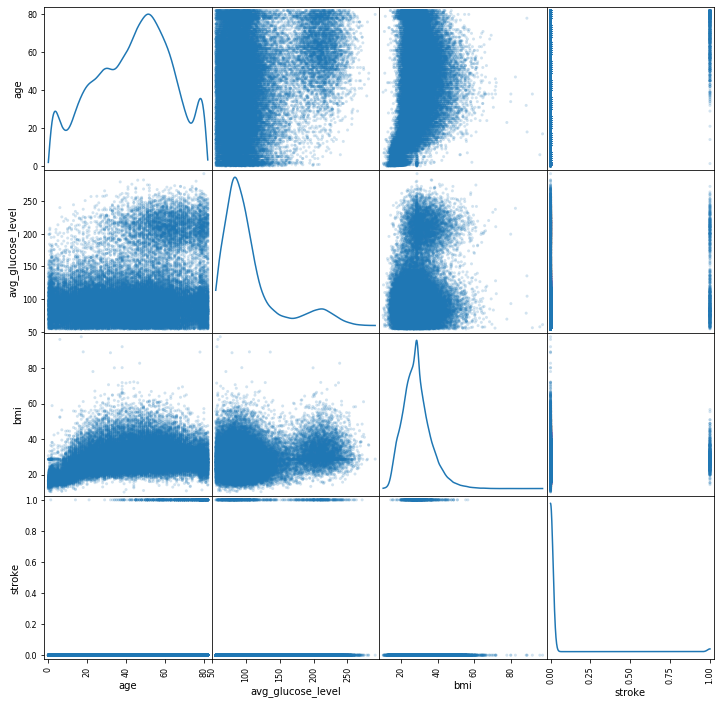

In [7]:
df = train_f.toPandas()
df = df[['age', 'ever_married', 'avg_glucose_level', 'bmi', 'stroke']]

from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = 0.2, figsize = (12, 12), diagonal = 'kde')

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# indexing all categorical columns in the dataset
indexer1 = StringIndexer(inputCol='gender', 
                         outputCol='genderIndex')
indexer2 = StringIndexer(inputCol='ever_married', 
                         outputCol='ever_marriedIndex')
indexer3 = StringIndexer(inputCol='work_type', 
                         outputCol='work_typeIndex')
indexer4 = StringIndexer(inputCol='Residence_type', 
                         outputCol='Residence_typeIndex')
indexer5 = StringIndexer(inputCol='smoking_status', 
                         outputCol='smoking_statusIndex')

# Doing one hot encoding of indexed data
encoder = OneHotEncoderEstimator(
    inputCols=['genderIndex', 'ever_marriedIndex', 'work_typeIndex', \
               'Residence_typeIndex', 'smoking_statusIndex'],
    outputCols=['genderVec', 'ever_marriedVec', 'work_typeVec', \
                'Residence_typeVec', 'smoking_statusVec'])

assembler = VectorAssembler(inputCols=['genderVec', 
                                       'age', 
                                       'hypertension', 
                                       'heart_disease', 
                                       'ever_marriedVec',
                                       'work_typeVec',
                                       'Residence_typeVec',
                                       'avg_glucose_level',
                                       'bmi',
                                       'smoking_statusVec'], 
                            outputCol='features')


In [10]:
# use decision tree classifier
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='stroke', featuresCol='features')

# construct pipe-line
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, \
                            indexer5, encoder, assembler, dtc])

# train the model
train_data, val_data = train_f.randomSplit([0.7,0.3])
model_dtc = pipeline.fit(train_data)
dtc_predictions = model_dtc.transform(val_data)

# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(
    labelCol='stroke', 
    predictionCol='prediction', 
    metricName='accuracy')
acc_dtc = acc_evaluator.evaluate(dtc_predictions)
print('Accuracy of Decision Tree is: {:2.2f}%'.format(acc_dtc * 100))

Accuracy of Decision Tree is:  98.01%


In [11]:
# use SVM
from pyspark.ml.classification import LinearSVC
classifier = LinearSVC(maxIter=10, 
                       regParam=0.1, 
                       labelCol='stroke', 
                       featuresCol='features')
pipeline_2 = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, \
                              indexer5, encoder, assembler, classifier])
model = pipeline_2.fit(train_data)

# predict and evaluate
train_data, val_data = train_f.randomSplit([0.7,0.3])
pred = model.transform(val_data)
acc_evaluator_2 = MulticlassClassificationEvaluator(
    labelCol='stroke', 
    predictionCol='prediction', 
    metricName='accuracy')
acc = acc_evaluator_2.evaluate(pred)
print('Accuracy of SVM is: {0: 2.2f}%'.format(acc * 100))

Accuracy of SVM is:  98.25%


In [0]:
import matplotlib
import matplotlib.pyplot as plt

from numpy.random import rand
from numpy import pi, arctan
import os

df = pd.read_csv('./train_2v.csv')
df.drop(['id'], axis = 1, inplace=True)

In [0]:
# fill in missing values for smoking status
# As this is categorical data, we will add one data type 
# "No Info" for the missing one
df['smoking_status'].fillna('No Info', inplace=True)

# fill in miss values for bmi 
# as this is numecial data , simply fill missing values with mean
mean_bmi = df['bmi'].mean()
df['bmi'].fillna(mean_bmi, inplace=True)

In [14]:
# encode gender
df['gender'] = (df['gender'] == 'Male').astype(int)

# encode age
min_val, max_val = df['age'].min(), df['age'].max()
df['age'] = (df['age'] - min_val) / (max_val - min_val)

#encode ever_married
df['ever_married'] = (df['ever_married'] == 'Yes').astype(int)

#encode Residence_type
df['Residence_type'] = (df['Residence_type'] == 'Urban').astype(int)

# encode avg_glucose_level
min_val, max_val = df['avg_glucose_level'].min(), df['avg_glucose_level'].max()
df['avg_glucose_level'] = (df['avg_glucose_level'] - min_val) / (max_val - min_val)

# encode bmi
min_val, max_val = df['bmi'].min(), df['bmi'].max()
df['bmi'] = (df['bmi'] - min_val) / (max_val - min_val)

# encode work_type
work_dict = {
    'children': .0,
    'Never_worked': .25, 
    'Govt_job': .5, 
    'Self_employed': .75, 
    'Private': 1.0}
df['work_type'] = df['work_type'].map(work_dict).fillna(0.5)

# encode smoking_status
smoking_dict = {
    'never smoked': .0,
    'formerly smoked': .5, 
    'No info': .5, 
    'smokes': 1.0}
df['smoking_status'] = df['smoking_status'].map(smoking_dict)

print(df.head())

   gender       age  hypertension  ...       bmi  smoking_status  stroke
0       1  0.035645             0  ...  0.090286             NaN       0
1       1  0.707031             1  ...  0.332571             0.0       0
2       0  0.096680             0  ...  0.085714             NaN       0
3       0  0.853516             0  ...  0.294857             0.5       0
4       1  0.169922             0  ...  0.102857             NaN       0

[5 rows x 11 columns]


In [0]:
def cface(ax, x1, x2, x3, x4, x5, x6, x7, 
          x8, x9, x10, x11, x12, x13, x14, 
          x15, x16, x17, x18):
    # x1 = height  of upper face -- fixed to 0.9
    # x2 = overlap of lower face -- gender
    # x3 = half of vertical size of face -- age
    # x4 = width of upper face -- hypertension
    # x5 = width of lower face -- heart_disease
    # x6 = length of nose -- ever_married
    # x7 = vertical position of mouth -- work_type
    # x8 = curvature of mouth -- Residence_type
    # x9 = width of mouth -- avg_glucose_level
    # x10 = vertical position of eyes -- bmi
    # x11 = separation of eyes -- smoking_status

    # x12 = slant of eyes
    # x13 = eccentricity of eyes
    # x14 = size of eyes -- stroke
    # x15 = position of pupils

    # x16 = vertical position of eyebrows
    # x17 = slant of eyebrows
    # x18 = size of eyebrows
    
    # transform some values so that input between 0,1 
    # yields variety of output
    x3 = 1.9 * (x3 - .5)
    x4 = (x4 + .25)
    x5 = (x5 + .2)
    x6 = .3 * (x6 + .01)
    x8 = 5 * (x8 + .001)
    x11 /= 5
    x12 = 2 * (x12 - .5)
    x13 += .05
    x14 += .1
    x15 = .5 * (x15 - .5)
    x16 = .25 * x16
    x17 = .5 * (x17 - .5)
    x18 = .5 * (x18 + .1)

    # top of face, in box with l=-x4, r=x4, t=x1, b=x3
    e = matplotlib.patches.Ellipse(
        xy=(0, (x1 + x3) / 2), 
        width=2 * x4, 
        height=(x1 - x3), 
        fc='white', 
        edgecolor='black', 
        linewidth=2)
    # e.set_clip_box(ax.bbox)
    # e.set_facecolor([0,0,0])
    ax.add_artist(e)

    # bottom of face, in box with l=-x5, r=x5, b=-x1, t=x2+x3
    e = matplotlib.patches.Ellipse(
        xy=(0, (- x1 + x2 + x3) / 2), 
        width=2 * x5, 
        height=(x1 + x2 + x3), 
        fc='white', 
        edgecolor='black', 
        linewidth=2)
    ax.add_artist(e)

    # cover overlaps
    e = matplotlib.patches.Ellipse(
        xy=(0,(x1 + x3)/2), 
        width=2 * x4, 
        height=(x1 - x3), 
        fc='white', 
        edgecolor='black', 
        ec='none')
    ax.add_artist(e)
    e = matplotlib.patches.Ellipse(
        xy=(0, (- x1 + x2 + x3) / 2), 
        width=2 * x5, 
        height=(x1 + x2 + x3), 
        fc='white', 
        edgecolor='black', 
        ec='none')
    ax.add_artist(e)
    
    # draw nose
    ax.plot([0, 0], [- x6 / 2, x6 / 2], 'k')
    
    # draw mouth
    p = matplotlib.patches.Arc(
        xy=(0, - x7 + .5 / x8), 
        width=1 / x8, 
        height=1 / x8, 
        theta1=270 - 180 / pi * arctan(x8 * x9), 
        theta2=270 + 180 / pi * arctan(x8 * x9))
    ax.add_artist(p)
    
    # draw eyes
    p = matplotlib.patches.Ellipse(
        xy=(- x11 - x14 / 2, x10), 
        width=x14, 
        height=x13 * x14, 
        angle=-180 / pi * x12, 
        facecolor='white', 
        edgecolor='black')
    ax.add_artist(p)
    
    p = matplotlib.patches.Ellipse(
        xy=(x11 + x14 / 2, x10), 
        width=x14, 
        height=x13 * x14, 
        angle=180 / pi * x12, 
        facecolor='white', 
        edgecolor='black')
    ax.add_artist(p)

    # draw pupils
    p = matplotlib.patches.Ellipse(
        xy=(- x11 - x14 / 2 - x15 * x14 / 2, x10), 
        width=.05, 
        height=.05, 
        facecolor='black')
    ax.add_artist(p)
    p = matplotlib.patches.Ellipse(
        xy=(x11 + x14 / 2 - x15 * x14 / 2, x10), 
        width=.05, 
        height=.05, 
        facecolor='black')
    ax.add_artist(p)
    
    # draw eyebrows
    ax.plot(
        [- x11 - x14 / 2 - x14 * x18 / 2, - x11 - x14 / 2 + x14 * x18 / 2], 
        [x10 + x13 * x14 * (x16 + x17), x10 + x13 * x14 * (x16 - x17)], 
        'k')
    ax.plot(
        [x11 + x14 / 2 + x14 * x18 / 2, x11 + x14 / 2- x14 * x18 / 2], 
        [x10 + x13 * x14 * (x16 + x17), x10 + x13 * x14 * (x16 - x17)], 
        'k')

In [0]:
with_stroke = df[df['stroke'] > 0]
wo_stroke = df[df['stroke'] < 1]

# take 15 entries from with_stroke and 10 from w/o
df = with_stroke[:15].append(
    wo_stroke[:10], 
    ignore_index=True)

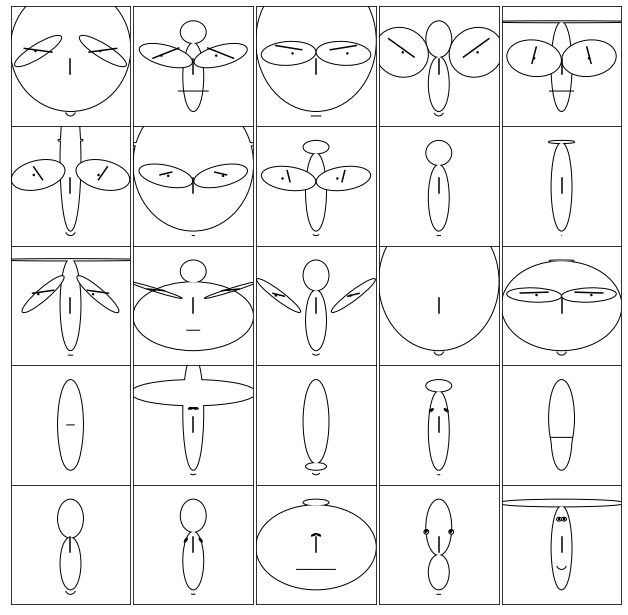

In [17]:
fig = plt.figure(figsize=(11, 11))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, aspect='equal')
    cface(ax, 0.9, 
          *list(df.iloc[i])[:-1], 
          *rand(2), 
          list(df.iloc[i])[-1], 
          *rand(4))
    ax.axis([-1.2, 1.2, -1.2, 1.2])
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(hspace=0, wspace=0)
plt.show()